In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ApiClient
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

In [4]:
client = ApiClient()

In [5]:
client.create(
    [
        client.make_msg(
            "You are image descripto. Respond with json of this format: {'description': what you see, 'style': stylistics of the image}",
            role=ROLE_SYSTEM,
        ),
        client.make_msg(
            text="What's in this image?",
            img="https://cdn.midjourney.com/ca13f713-b289-45ee-92fe-b1276a1dc833/0_3.webp",
        ),
    ],
    format=JSON_MODE,
)

'{"description": "The image features an animated female character with bright red hair and striking blue eyes. She is wearing a black bikini, positioned in an alluring pose with one arm raised above her head. The background is a simple and soft blue, which nicely complements the vibrant red of her hair, creating a visually striking contrast.", "style": "The artwork is rendered in a highly detailed, realistic style with a strong focus on vibrant colors and smooth shading. The character\'s expression and pose are lively and engaging, typical of modern digital illustrations aimed at a youthful audience."}'

In [6]:
plt.plot(np.sin(np.array(range(300)) * 0.1))

client.create(
    [
        client.make_msg(
            "You are image descripto. Respond with json of this format: {'description': what you see, 'style': stylistics of the image}",
            role=ROLE_SYSTEM,
        ),
        client.make_msg(
            text="What's in this image?",
            img=plt,
        ),
    ],
    format=JSON_MODE,
)

'{\n  "description": "The image displays a sinusoidal wave pattern plotted on a coordinate grid. The horizontal axis is labeled with numbers ranging from 0 to 300 at intervals of 50, while the vertical axis ranges from -1.00 to 1.00, marked at intervals of 0.25. The wave oscillates evenly above and below a horizontal line at y = 0.",\n  "style": "Analytical, graphical representation of data. The graph uses a simple color scheme with a blue wave on a light gray grid background."\n}'

In [7]:
day_history = get_day_history("TON")
week_history = get_week_history("TON")
month_history = get_month_history("TON")

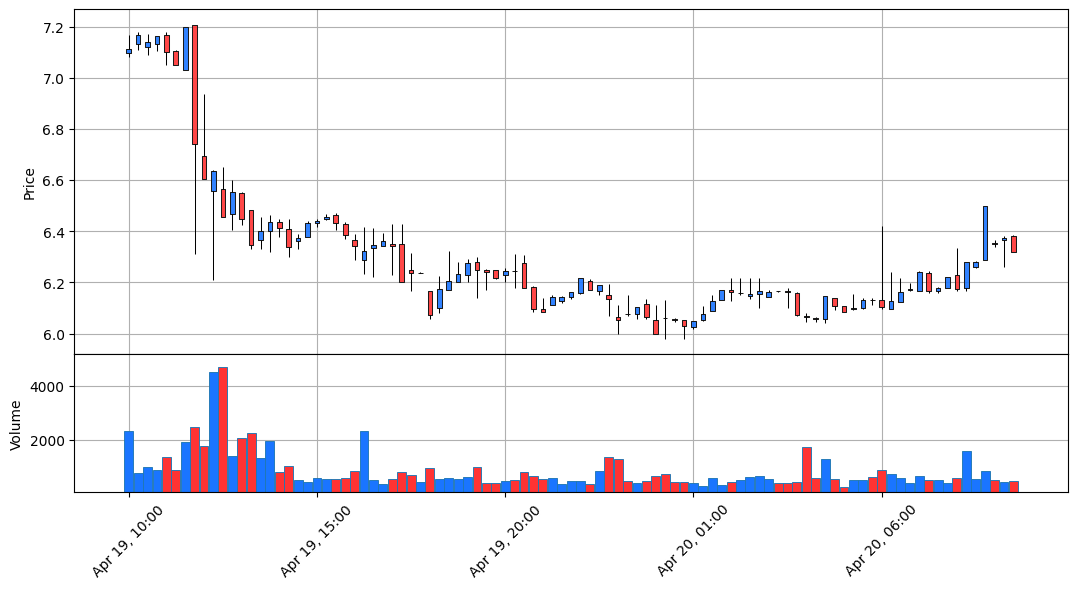

In [8]:
make_candlebars(day_history)

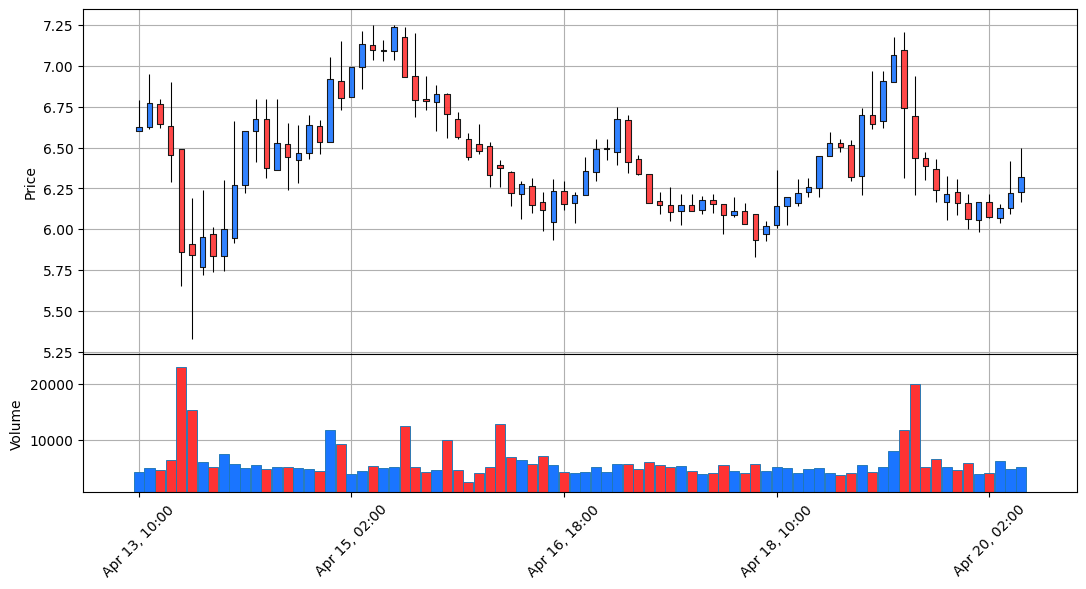

In [9]:
make_candlebars(week_history)

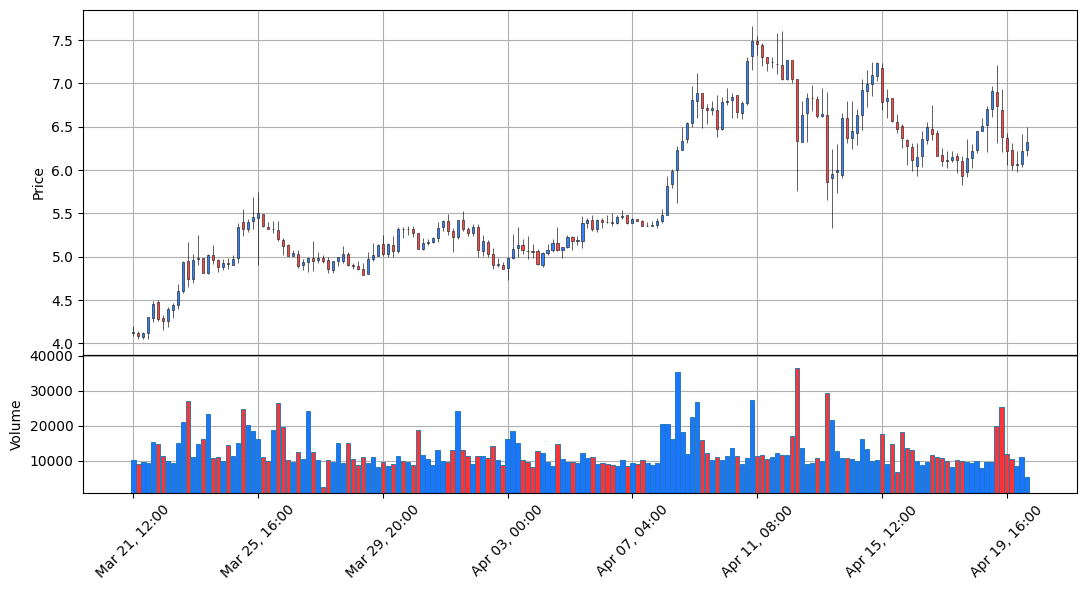

In [10]:
make_candlebars(month_history)

In [11]:
day_buf = make_candlebars(day_history, useBuf=True)
week_buf = make_candlebars(week_history, useBuf=True)
month_buf = make_candlebars(month_history, useBuf=True)

response = client.create(
    [
        client.make_msg(
            """You are professional trader.
            You have deep knowledge of cryptocurrencies and trading markets, and you can maximize profits the most efficiently.
            You trade in USDT.
            
            You an only buy or sell at the current price, you can not set stop loss.
            Respond with json of this format: 
            {
                'description': what you see on charts, general short and long term trends, 
                'trend_analysys': rough prediction of near future development of coin,
                'techical_analysys': visual technical analysis of plot and indicators,
                'optimal_strategy": optimal trading strategy to maximize profits in this situation,
                'final_decision': what to do, possible variants: 'sell', 'buy', 'hold' (do nothing),
                'amount': USDT amount of coin to byu or sell, 0 if action is 'hold'
            }
            """,
            role=ROLE_SYSTEM,
        ),
        client.make_msg(
            text="This is price history of this coin in the last day",
            img=day_buf,
        ),
        client.make_msg(
            text="This is price history of this coin in the last week",
            img=week_buf,
        ),
        client.make_msg(
            text="This is price history of this coin in the last month",
            img=month_buf,
        ),
        client.make_msg(
            text="""
            This is price charts of TON coin, you need to come up with optimal strategy at this moment.
            Permorm price and signal analisys of this graph of this crypto coin.
            
            your current funds:
            {
                TON: 34.73,
                USDT: 56.14
            }
            """,
        ),
    ],
    format=JSON_MODE,
)

json.loads(response)

{'description': "The provided price charts for the TON coin indicate several key observations. Over the last month, the coin's price showed a significant uptrend, moving from around $4.50 to a high of approximately $7.25. Then, it seems to have experienced some consolidation within a price range of approximately $6.00 to $7.00. Over the last week, despite some fluctuation, the price somewhat stabilized between $6.25 and $6.75. The most recent day shows increased volatility and trading volume, with a sudden price spike towards $7.00.",
 'trend_analysis': "The overall trend for TON coin looks to be bullish in the long-term, given the steady climb over the past month. However, the recent consolidation phase suggests some uncertainty about the immediate next direction of price movement. The sharp increase in price on the latest day's chart indicates increased investor interest or a possible reaction to news/events.",
 'technical_analysis': 'Technical signals include a test of resistance le

In [14]:
napi = NewsApi()
napi.get_news("ton+coin", start_date="2024-04-15")

[{'source': 'CNET',
  'title': 'Feeling Blue For Not Being Green? This Card Offers 6% Cash Back for Eco-Friendly Purchases - CNET',
  'description': 'The lower your carbon emissions drop, the more your bank account balance could increase.'},
 {'source': 'Zoomit.ir',
  'title': 'چطور از تلگرام بیزنس درآمدزایی کنیم؟',
  'description': 'تلگرام هم مثل بسیاری از پلتفرم\u200cهای بزرگ تولید محتوا، امکان درآمدزایی را فراهم کرده است و صاحبان کانال\u200cها می\u200cتوانند از این برنامه درآمد کسب کنند.'},
 {'source': 'Asriran.com',
  'title': 'چطور از تلگرام بیزنس درآمدزایی کنیم؟',
  'description': 'تلگرام هم مثل بسیاری از پلتفرم\u200cهای بزرگ تولید محتوا، امکان درآمدزایی را فراهم کرده است و صاحبان کانال\u200cها می\u200cتوانند از این برنامه درآمد کسب کنند.'},
 {'source': 'Webnews.it',
  'title': '2 crypto e una prevendita che possono esplodere nel mese di aprile',
  'description': 'Bitcoin ancora in rosso ma queste due crypto e una prevendita promettono di fare faville nella seconda parte di april